# Модуль 3. Проведение кластерного анализа и выявление зависимостей в данных

## 0 Предисловие

### 0.1 Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import cv2

In [ ]:
from PIL import Image

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

In [ ]:
from scipy.io import wavfile

In [ ]:
import pickle as pkl

In [ ]:
import scipy.signal as signal

In [ ]:
RANDOM_STATE=666

### 0.2 Загрузка результатов модуля B

In [ ]:
%%time
try:
    with open('..\\C1_M2\\exp_df.data', 'rb') as f:
        exp_df = pkl.load(f)
except Exception as e:
    print(e)

CPU times: total: 62.5 ms
Wall time: 59.8 ms


In [ ]:
exp_df.sample(5)

,co2,a,vl,v,w,ws,t,volt,num_experiment,0,...,76794,76795,76796,76797,76798,76799,p,t_teplo,acoustic_info,herz
1564,397,0.330801,90,754.0,-510.683010,4.5,27.6,46.099305,6,130,...,128,128,128,128,128,128,15.249701,7893599892527608949,-6696486925258522488,500000
1792,300,1.410549,90,752.0,-126.400381,4.8,25.2,189.667281,7,126,...,128,128,128,128,128,128,267.535058,7893599892527608949,-6696486925258522488,1000000
2261,306,-0.997850,90,751.0,-17.363543,5.9,27.4,-132.097746,9,127,...,128,128,128,128,128,128,131.813789,7893599892527608949,-6696486925258522488,1000000
847,317,-1.277721,91,750.0,48.181946,4.2,26.9,-167.009602,4,129,...,128,128,128,128,128,128,213.391593,7893599892527608949,-6696486925258522488,500000
1032,386,-1.626536,91,750.0,297.548639,4.4,28.8,-217.410733,4,128,...,128,128,128,128,128,128,353.626392,7893599892527608949,-6696486925258522488,500000


### 0.3 Генерация признака температуры из видео

In [ ]:
temp_1 = np.linspace(25.3, 95.7, exp_df.query('num_experiment == 1').shape[0])

In [ ]:
temp_2 = np.linspace(26.4, 96.4, exp_df.query('num_experiment == 2').shape[0])

In [ ]:
temp_3 = np.linspace(26.3, 96.5, exp_df.query('num_experiment == 3').shape[0])

In [ ]:
temp_4 = np.linspace(27.5, 96.5, exp_df.query('num_experiment == 4').shape[0])

In [ ]:
temp_5 = np.linspace(26.0, 96.2, exp_df.query('num_experiment == 5').shape[0])

In [ ]:
temp_6 = np.linspace(26.2, 96.4, exp_df.query('num_experiment == 6').shape[0])

In [ ]:
temp_7 = np.linspace(25.0, 96.4, exp_df.query('num_experiment == 7').shape[0])

In [ ]:
temp_8 = np.linspace(24.9, 96.2, exp_df.query('num_experiment == 8').shape[0])

In [ ]:
temp_9 = np.linspace(24.5, 96.3, exp_df.query('num_experiment == 9').shape[0])

In [ ]:
temp = np.concatenate((temp_1, temp_2, temp_3, temp_4, temp_5, temp_6, temp_7, temp_8, temp_9))

In [ ]:
temp.shape

(2544,)

In [ ]:
exp_df.shape

(2544, 76813)

In [ ]:
exp_df['temp'] = temp

## 1. Выбор переменных для построения модели

### 1.1 Корреляционные матрицы

Построим корреляционную матрицу для признаков, НЕ построенных из кадров видео

In [ ]:
cols = ['co2', 'a', 'vl', 'v', 'w', 'ws', 't', 'volt', 'num_experiment', 'p', 'herz', 'temp']

In [ ]:
exp_corr = exp_df[cols].corr()

In [ ]:
exp_corr

,co2,a,vl,v,w,ws,t,volt,num_experiment,p,herz,temp
co2,1.000000,0.008914,-0.003186,0.033440,-0.009468,-0.007910,-0.007894,0.009522,-0.034680,0.047175,-0.034659,-0.013886
a,0.008914,1.000000,0.031787,0.027597,-0.125315,0.005417,0.000936,0.999271,-0.056974,-0.038147,-0.056613,0.153207
vl,-0.003186,0.031787,1.000000,-0.000493,-0.008724,0.009549,0.018889,0.031815,0.014310,-0.014342,0.011391,0.066320
v,0.033440,0.027597,-0.000493,1.000000,0.029693,0.030593,-0.018456,0.026792,-0.004263,-0.007534,-0.002211,-0.002452
w,-0.009468,-0.125315,-0.008724,0.029693,1.000000,-0.016549,-0.012166,-0.125082,0.033158,-0.039744,0.029369,-0.032009
ws,-0.007910,0.005417,0.009549,0.030593,-0.016549,1.000000,0.036070,0.005664,0.011257,-0.010258,0.016092,0.028267
t,-0.007894,0.000936,0.018889,-0.018456,-0.012166,0.036070,1.000000,0.003111,0.061089,-0.009637,0.051553,0.004831
volt,0.009522,0.999271,0.031815,0.026792,-0.125082,0.005664,0.003111,1.000000,-0.058154,-0.036884,-0.058241,0.151722
num_experiment,-0.034680,-0.056974,0.014310,-0.004263,0.033158,0.011257,0.061089,-0.058154,1.000000,-0.305934,0.948962,-0.010656
p,0.047175,-0.038147,-0.014342,-0.007534,-0.039744,-0.010258,-0.009637,-0.036884,-0.305934,1.000000,-0.300151,-0.244252


Карта корреляций

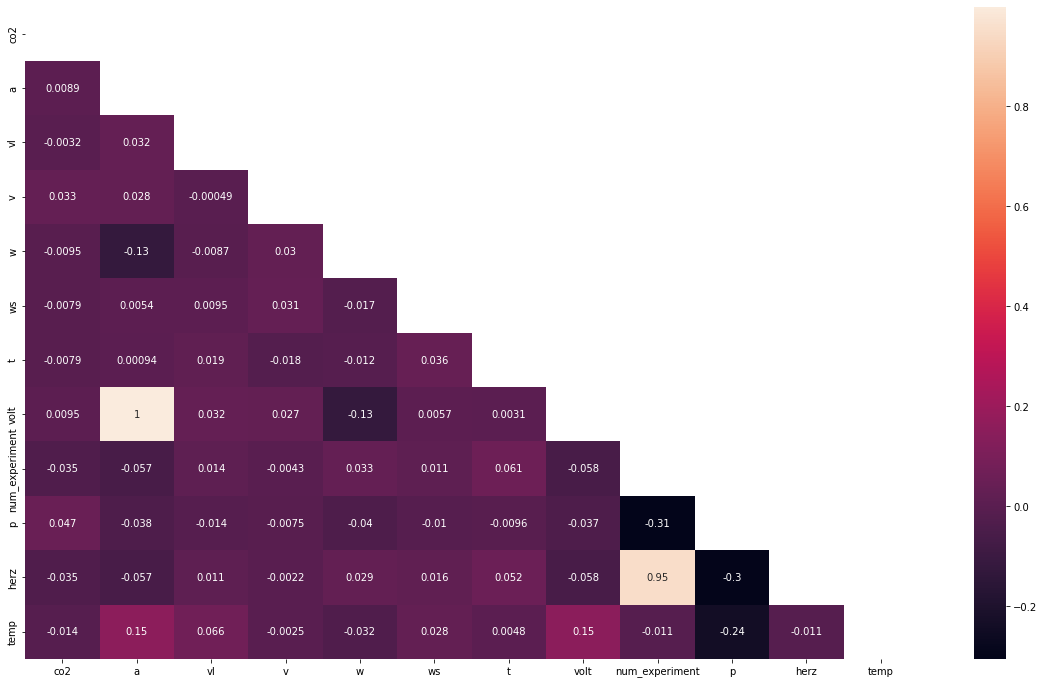

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(exp_corr, annot=True, mask=np.triu(exp_corr));

Наблюдается очень сильная положительная корреляция между напряжением и током (Закона Ома: \$R = U / I$)

Также очень сильная корреляция между номером эксперимента и частотой тока.

Выделим признаки с сильнейшими корреляциями

In [ ]:
c1 = exp_corr.abs().unstack()
c1[(c1 < 1) & (c1 > 0.9)].sort_values(ascending = False)

a               volt              0.999271
volt            a                 0.999271
num_experiment  herz              0.948962
herz            num_experiment    0.948962
dtype: float64

### 1.2 Подбор переменных с помощью корреляционных матриц

Поскольку переменные с очень сильной корреляцией предоставляют идентичную информацию модели, то необходимо одну из таких переменных удалить.

В данном датасете можно удалить **номер эксперимента** и **напряжение**, т.к. оно вычислимо из оставшихся **мощности** и **тока**.

In [ ]:
cleared_cols = exp_df.columns.tolist()

In [ ]:
cleared_cols.remove('num_experiment')
cleared_cols.remove('volt')

### 1.3 Подбор переменных с помощью других методов подбора

#### 1.3.1 Важность признаков с помощью дерева решений

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor()

In [ ]:
X = exp_df.drop('temp', axis=1)
y = exp_df.temp

In [ ]:
%%time
dtr.fit(X, y)

CPU times: total: 36.6 s
Wall time: 36.6 s


DecisionTreeRegressor()

In [ ]:
importances_df = pd.DataFrame({'importance': dtr.feature_importances_}, index=X.columns).sort_values('importance', ascending=False)
importances_df.head(20)

,importance
48130,0.748504
45340,0.093891
49729,0.093009
49667,0.011873
43906,0.011873
814,0.011489
41029,0.011381
51628,0.001548
47160,0.001548
50331,0.001421


Видим, что для задачи определения температуры были отобраны наиболее значимые пиксели из видео.

In [ ]:
# признаки, имеющую нулевую важность
importances_df.query('importance == 0')

,importance
50932,0.0
51493,0.0
50934,0.0
51410,0.0
50967,0.0
...,...
25857,0.0
25856,0.0
25855,0.0
25854,0.0


Также видим, что 75250 признаков не важны для алгоритма дерева решений.

In [ ]:
q_3 = importances_df.query('importance > 0').quantile(0.75).values[0]

In [ ]:
importances_df.query('importance > @q_3').shape

(395, 1)

Примем важными 391 признак, имеющий ненулевую важность и входящий в 4 квантиль

In [ ]:
tree_best_features = importances_df.query('importance > @q_3')['importance'].index.to_list()

#### 1.3.2 Важность с помощью статистических методов

In [ ]:
from sklearn.feature_selection import SelectKBest

In [ ]:
kbest = SelectKBest(k=100)

In [ ]:
kbest.fit(X, y)

SelectKBest(k=100)

In [ ]:
kbest_best_features = kbest.get_feature_names_out().tolist()

Оставим те признаки, которые получились по результатам важности DecisionTree и KBest

In [ ]:
kbest_best_features = [int(feat[1:]) for feat in kbest_best_features]

In [ ]:
best_features = list(set(tree_best_features).union(set(kbest_best_features)))

In [ ]:
len(best_features)

495

In [ ]:
print(best_features)

[48130, 32773, 72709, 71689, 3081, 25610, 76810, 36877, 42000, 52240, 21527, 71704, 66586, 53276, 10269, 62493, 56353, 42020, 42021, 17447, 40, 63528, 27688, 47154, 47159, 47160, 27706, 58427, 31804, 58428, 1091, 'num_experiment', 41029, 67660, 31820, 15438, 75852, 57424, 26705, 75853, 75854, 47188, 30805, 75855, 1111, 75857, 75861, 75863, 46171, 73820, 21596, 75865, 75866, 12384, 97, 75868, 75869, 75870, 71781, 75871, 75872, 67688, 31851, 42096, 30851, 26756, 50310, 74889, 25739, 74892, 74897, 74899, 10388, 37014, 45207, 44183, 44185, 41114, 50331, 74903, 74904, 49310, 74905, 160, 74906, 74908, 40099, 74909, 24741, 74910, 74912, 8363, 20654, 33969, 29874, 40126, 24767, 24768, 15555, 40133, 56528, 63697, 23761, 70866, 40145, 3280, 22742, 30934, 45271, 53465, 11478, 49371, 3288, 't', 44254, 22752, 59617, 39138, 74130, 70891, 3309, 18673, 48373, 48374, 12535, 74134, 37116, 39170, 7426, 74136, 48390, 23815, 11530, 28941, 47380, 38165, 64790, 24855, 44312, 28954, 68891, 45340, 47388, 59678

Итого 491 признак.

### 1.4 Итоговый датасет

Оставляем лучшие признаки и удаляем с очень сильной корреляцией

In [ ]:
features = best_features.copy() + ['temp']
features.remove('num_experiment')
features.remove('volt')
features = list(map(str, features))

In [ ]:
exp_df.columns = list(map(str, exp_df.columns.tolist()))

In [ ]:
exp_result_df = pd.DataFrame()

for col in features:
    if col in exp_df.columns:
        exp_result_df[col] = exp_df[col]

Итоговый датасет

In [ ]:
exp_result_df

,48130,32773,72709,71689,3081,25610,36877,42000,52240,21527,...,7137,12258,5095,12265,27627,49134,53238,62459,21500,temp
0,25,37,136,187,155,148,40,42,25,89,...,171,164,159,158,54,214,19,215,136,25.300000
1,23,37,136,185,157,149,40,41,24,90,...,173,163,159,159,54,214,17,214,136,25.548763
2,22,35,135,182,156,145,40,42,24,89,...,172,161,158,157,52,212,18,214,135,25.797527
3,22,35,133,179,152,142,40,42,24,88,...,170,158,157,155,52,208,17,211,133,26.046290
4,25,35,136,185,153,149,39,40,24,89,...,173,163,158,158,53,215,18,215,135,26.295053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,199,223,119,14,9,9,250,241,193,170,...,44,59,157,56,244,19,189,19,9,95.309655
2540,199,226,119,13,9,9,249,241,194,170,...,44,60,157,56,244,20,191,19,8,95.557241
2541,201,227,119,13,9,8,248,241,196,174,...,45,60,157,56,245,20,192,19,10,95.804828
2542,202,227,119,12,9,9,248,241,198,175,...,45,60,157,56,245,20,193,19,9,96.052414


## 2 Поиск режимов кипения

Репрезентация данных на двумерную плоскость

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne_test = TSNE()

In [ ]:
rep_tsne = tsne_test.fit_transform(exp_result_df)

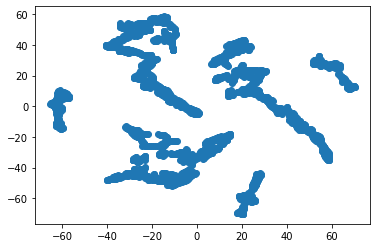

In [ ]:
plt.scatter(
    rep_tsne[:,0],
    rep_tsne[:,1]
);

Определим 3 режима кипения по третям температурных режимов

In [ ]:
q_1 = exp_result_df['temp'].quantile(0.33)
q_2 = exp_result_df['temp'].quantile(0.66)

In [ ]:
q_1, q_2

(49.01536141857897, 72.34297526501767)

### 2.1 Кластеризация по температурным режимам

Отобразим на графике три кластера с температурным режимом, где:

ниже 49C - синий

49С-72С - зеленый

выше 72С - красный

In [ ]:
reg = exp_result_df['temp'].apply(lambda x: 1 if x < q_1 else 2 if x < q_2 else 3)

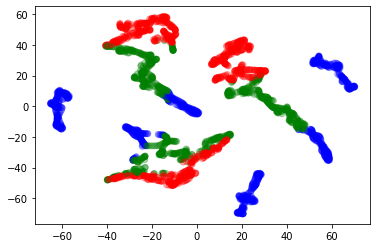

In [ ]:
plt.scatter(
    rep_tsne[:,0],
    rep_tsne[:,1],
    c=reg.replace({1: 'b', 2: 'g', 3: 'r'}),
    alpha=0.3
);

### 2.1 KMeans

Проанализируем разбиение на 3 кластера с помощью алгоритма близжайших соседей

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=3)

In [ ]:
kmeans.fit(exp_result_df)

KMeans(n_clusters=3)

In [ ]:
from sklearn.metrics import rand_score, v_measure_score, silhouette_score

Отобразим кластеры

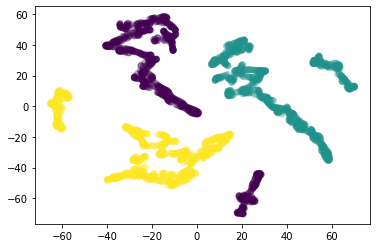

In [ ]:
plt.scatter(
    rep_tsne[:,0],
    rep_tsne[:,1],
    c=kmeans.labels_,
    alpha=0.3
);

Оценим результат кластеризации с помощью метрик

In [ ]:
vals = pd.crosstab(reg, kmeans.labels_)
vals.columns = ['cluster1', 'cluster2', 'cluster3']
vals

,cluster1,cluster2,cluster3
temp,,,
1,270,292,278
2,279,279,281
3,289,288,288


In [ ]:
rand_score(reg, kmeans.labels_)

0.5554018059193198

In [ ]:
v_measure_score(reg, kmeans.labels_)

0.00011326478637132837

In [ ]:
silhouette_score(exp_result_df, kmeans.labels_)

0.9965435359195245

Силуэт находится в диапазоне от -1 до +1. В данном случае значение близко к 1, что означает, что объект хорошо соответствует своему собственному кластеру и плохо соответствует соседним кластерам.

### 2.2 Алгоритм DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(n_jobs=-1)

In [ ]:
dbscan.fit(exp_result_df)

DBSCAN(n_jobs=-1)

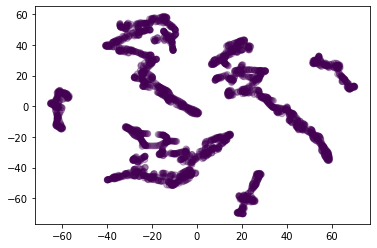

In [ ]:
plt.scatter(
    rep_tsne[:,0],
    rep_tsne[:,1],
    c=dbscan.labels_,
    alpha=0.3
);

In [ ]:
rand_score(reg, dbscan.labels_)

0.33313826090612536

In [ ]:
v_measure_score(reg, dbscan.labels_)

0.0

### 2.3 Аггломеративная кластеризация

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
agg_cluster = AgglomerativeClustering(n_clusters=3)

In [ ]:
agg_cluster.fit(exp_result_df)

AgglomerativeClustering(n_clusters=3)

In [ ]:
agg_cluster.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

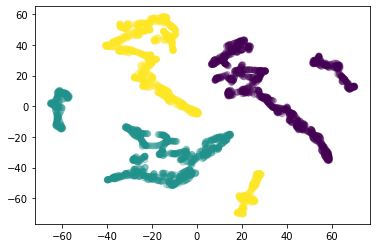

In [ ]:
plt.scatter(
    rep_tsne[:,0],
    rep_tsne[:,1],
    c=agg_cluster.labels_,
    alpha=0.3
);

In [ ]:
rand_score(reg, agg_cluster.labels_)

0.5554018059193198

In [ ]:
v_measure_score(reg, agg_cluster.labels_)

0.00011326478637132837

In [ ]:
silhouette_score(exp_result_df, agg_cluster.labels_)

0.9965435359195245

Результаты кластеризации KMeans и AgglomerativeClustering идентичны.

### 2.4 Оптимальное количество кластеров

С помощью метода локтя определим оптимальное количество кластеров для этой задачи

In [ ]:
inertia = []

for i in range(1, 10):
    model = KMeans(n_clusters=i)
    model.fit(exp_result_df)
    inertia.append(model.inertia_)

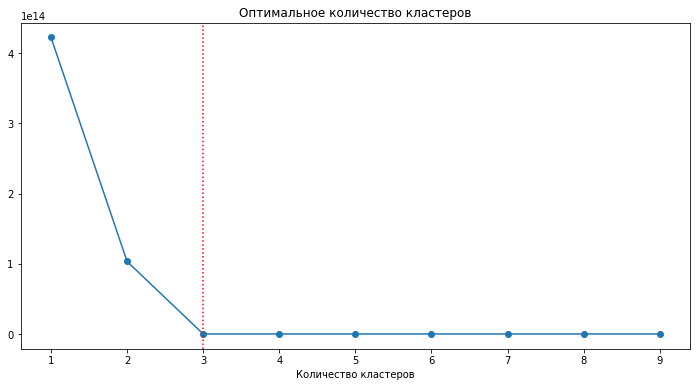

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(inertia)
plt.scatter(range(9), inertia)
plt.xticks(range(9), range(1, 10))
plt.xlabel('Количество кластеров')
plt.title('Оптимальное количество кластеров')
plt.axvline(2, linestyle=':', c='r');

Оптимальное количество - 3 кластера. Совпадает с режимами кипения

### 2.5 Режимы кипения

Дополним датасет признаком принадлежности к кластеру, выделенном с помощью KMeans

In [ ]:
exp_result_df['cluster'] = kmeans.labels_

In [ ]:
exp_result_df.query('cluster == 1')['temp'].sort_values()

2253    24.500000
2254    24.747586
1973    24.900000
2255    24.995172
1685    25.000000
          ...    
2542    96.052414
1971    96.151220
2252    96.200000
2543    96.300000
1972    96.400000
Name: temp, Length: 859, dtype: float64

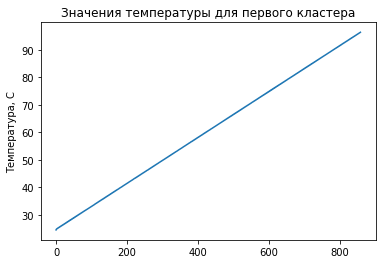

In [ ]:
plt.plot(range(859), exp_result_df.query('cluster == 1')['temp'].sort_values())
plt.title('Значения температуры для первого кластера')
plt.ylabel('Температура, C');

Алгоритмы кластеризации не справились с задачей нахождения режимов кипения.

Определим режимы кипения по температурным режимам по третям, как это было определено ранее.

In [ ]:
exp_result_df['mode'] = reg

## 3 Классификация режимов кипения

### 3.1 Подготовка данных для классификации

Разделяем выборку на объекты-цель (цель - режим кипения)

In [ ]:
X = exp_result_df.drop('mode', axis=1)
y = exp_result_df['mode']

Разбиваем данные на тренировочные и валидационные

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y)

### 3.2 Классификация

Всего 3 класса по режимам кипения:

In [ ]:
exp_result_df['mode'].unique()

array([1, 2, 3], dtype=int64)

In [ ]:
exp_result_df['mode'].nunique()

3

#### 3.2.1 Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logit = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

In [ ]:
%%time
logit.fit(X_train, y_train)

CPU times: total: 625 ms
Wall time: 141 ms


LogisticRegression(class_weight='balanced', random_state=666)

Оценка точности классификации

In [ ]:
from sklearn.metrics import classification_report, f1_score, mean_absolute_percentage_error

In [ ]:
print('Отчет по классификации, включая метрики precision(точность), recall(объём), f1-мера')
print(classification_report(y_test, logit.predict(X_test)))

Отчет по классификации, включая метрики precision(точность), recall(объём), f1-мера
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       277
           2       0.96      0.97      0.97       277
           3       0.99      0.98      0.98       286

    accuracy                           0.98       840
   macro avg       0.98      0.98      0.98       840
weighted avg       0.98      0.98      0.98       840



In [ ]:
# средняя абсолютная процентная ошибка (MAPE)
mean_absolute_percentage_error(y_test, logit.predict(X_test))

0.013293650793650793

Модель ошибается в ~1% случаев на этих данных

In [ ]:
# отдельно f1
f1_score(y_test, logit.predict(X_test), average='weighted')

0.9773919478648024

#### 3.2.2 Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [ ]:
%%time
rfc.fit(X_train, y_train)

CPU times: total: 266 ms
Wall time: 257 ms


RandomForestClassifier(class_weight='balanced', random_state=666)

Оценка точности классификации

In [ ]:
print('Отчет по классификации, включая метрики precision(точность), recall(объём), f1-мера')
print(classification_report(y_test, rfc.predict(X_test)))

Отчет по классификации, включая метрики precision(точность), recall(объём), f1-мера
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       277
           2       0.97      0.96      0.96       277
           3       0.99      0.99      0.99       286

    accuracy                           0.98       840
   macro avg       0.98      0.98      0.98       840
weighted avg       0.98      0.98      0.98       840



In [ ]:
# средняя абсолютная процентная ошибка (MAPE)
mean_absolute_percentage_error(y_test, rfc.predict(X_test))

0.014087301587301586

Модель ошибается в ~1% случаев на этих данных

In [ ]:
# отдельно f1
f1_score(y_test, rfc.predict(X_test), average='weighted')

0.9761730367258987

#### 3.2.3 Градиентный бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(random_state=RANDOM_STATE, verbose=1)

In [ ]:
%%time
gbc.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.9106            8.10s
         2           0.7646            9.53s
         3           0.6478            9.97s
         4           0.5524           10.13s
         5           0.4734           10.16s
         6           0.4073           10.16s
         7           0.3516           10.11s
         8           0.3045           10.06s
         9           0.2641            9.98s
        10           0.2295            9.91s
        20           0.0575            8.90s
        30           0.0150            7.81s
        40           0.0039            6.71s
        50           0.0010            5.59s
        60           0.0003            4.48s
        70           0.0001            3.36s
        80           0.0000            2.24s
        90           0.0000            1.12s
       100           0.0000            0.00s
CPU times: total: 11 s
Wall time: 11 s


GradientBoostingClassifier(random_state=666, verbose=1)

Оценка точности классификации

In [ ]:
print('Отчет по классификации, включая метрики precision(точность), recall(объём), f1-мера')
print(classification_report(y_test, gbc.predict(X_test)))

Отчет по классификации, включая метрики precision(точность), recall(объём), f1-мера
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       277
           2       1.00      1.00      1.00       277
           3       1.00      1.00      1.00       286

    accuracy                           1.00       840
   macro avg       1.00      1.00      1.00       840
weighted avg       1.00      1.00      1.00       840



In [ ]:
# средняя абсолютная процентная ошибка (MAPE)
mean_absolute_percentage_error(y_test, gbc.predict(X_test))

0.0

Модель вообще не ошибается на этих данных. Все признаки переобучения, но это уже совсем другая история...

In [ ]:
# отдельно f1
f1_score(y_test, gbc.predict(X_test), average='weighted')

1.0

## 4 Сохранение результатов

In [ ]:
%%time
try:
    with open('exp_df.data', 'wb') as f:
        pkl.dump(exp_result_df, f)
except Exception as e:
    print(e)

CPU times: total: 0 ns
Wall time: 3 ms
